# Deep Learning Mini-Challenge 1: Image Classification

**Author**: Lukas Reber

**Task**: Train a neural network to classify images from the CIFAR-10 dataset. Focus will be on the training and evaluation of the model, not on the data preprocessing. We will use PyTorch to implement a Multi Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) to classify images the images.

**Dataset**: The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

## Import dependencies & load data

In [1]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# check if gpu support on the m1 mac or cuda is available
if torch.backends.mps.is_available() & torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [4]:
device = torch.device("cpu")
print(device)

cpu


In [116]:
torch.manual_seed(10)
np.random.seed(10)

We can directly load the CIFAR-10 dataset from PyTorch's `torchvision` package. Since the data consists of images or range [0,255], we normalize the data to range [0,1]. (RGB values range from 0-255, therefore by dividing by 255 we normalize the data to range [0,1].)

In [3]:
# load the data and normalize it

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


cifar_test = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# cifar_train = CIFAR10('./data', train=True, download=True)
# cifar_test = CIFAR10('./data', train=False, download=True)

# x_train = torch.from_numpy(cifar_train.data).permute(0, 3, 1, 2).float() / 255
# x_test = torch.from_numpy(cifar_test.data).permute(0, 3, 1, 2).float() / 255

# y_train = torch.from_numpy(np.array(cifar_train.targets))
# y_test = torch.from_numpy(np.array(cifar_test.targets))

print(f'Shape: {cifar_train.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Shape: (50000, 32, 32, 3)


We now have the data in the correct shape and range. As we can see, there are 50000 training images, with three layers (RGB) and 32x32 pixels each. We can look at some random images from the training set to get a better idea of the data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

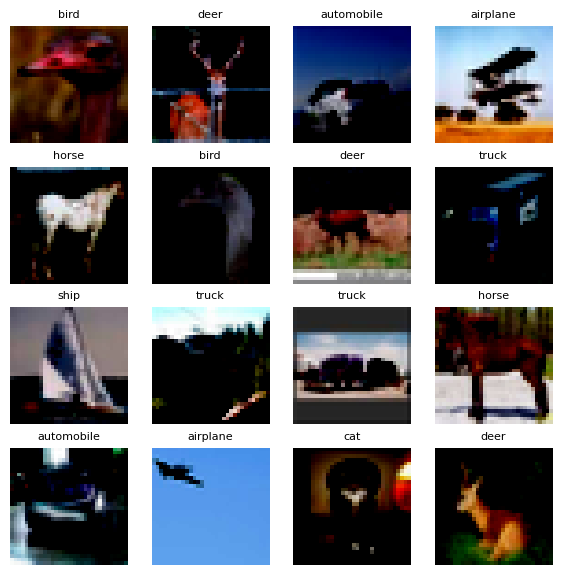

In [135]:
# plot sample images
rand_idx = np.random.randint(0, len(cifar_train), 16)
fig, axs = plt.subplots(4,4, figsize=(7,7))
for i, ax in enumerate(axs.flat):
    ax.imshow(cifar_train[rand_idx[i]][0].permute(1,2,0))
    ax.set_title(cifar_train.classes[cifar_train[rand_idx[i]][1]], size=8)
    ax.axis('off')

We can also see that the classes are balanced in the dataset.

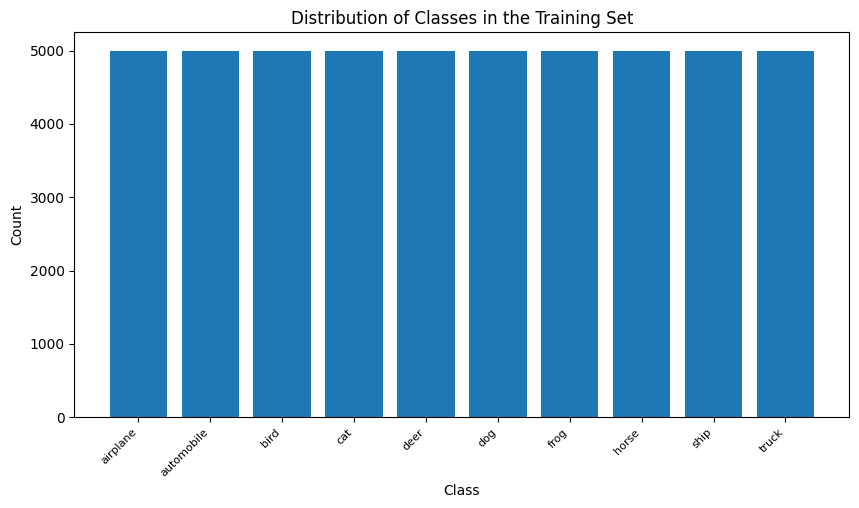

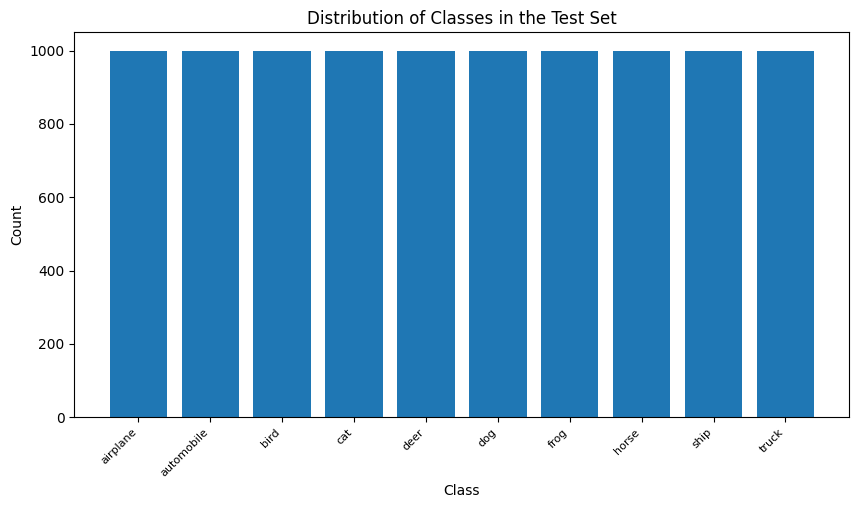

In [140]:
# display distribution of classes
values, counts = np.unique(cifar_train.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Training Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_train.classes, rotation=45, ha='right', size=8)
plt.show()

values, counts = np.unique(cifar_test.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Test Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_test.classes, rotation=45, ha='right', size=8)
plt.show()

Source:

- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- 

In [5]:
def model_training(modelclass, optimizer, traindata, criterion, epochs, device):
    model = modelclass()
    model = model.to(device)
    optimizer = optimizer(model)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(traindata, 0):

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

In [8]:
# define first model
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        
        self.fc1 = nn.Linear(32*32*3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        out = x.view(-1, 32*32*3)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return F.softmax(self.fc4(out), dim=1)

In order to train the model we need:
- A loss function: This is the function that we want to minimize. In this case we use the cross entropy loss.
- An optimizer: This is the algorithm that we use to update the weights of the model. In this case we use Stochastic Gradient Descent (SGD).
- Metrics: to monitor the performance of the model during training and evaluation. In this case we use accuracy.

In [11]:
# train the model
model_training(
    lambda: MultiLayerPerceptron(),
    lambda model: torch.optim.SGD(model.parameters(), lr=0.01),
    traindata=torch.utils.data.DataLoader(cifar_train, batch_size=100, shuffle=True),
    criterion=nn.CrossEntropyLoss(),
    epochs=2,
    device=device
)